## Telecom Churn Case Study
- Nandeesh N, and Amitkumar Maheshwari

### Brief Overview & Objectives:
- The telecommunications industry experiences an average of 15-25% annual churn rate.
- Retaining high profitable customers is the number one business goal.
- Churn prediction is usually more critical (and non-trivial) for prepaid customers.
- Usage-based churn: Customers who have not done any usage for a specified period of time.
- In the Indian and the southeast Asian market, approximately 80% of revenue comes from the top 20% customers. Thus, if we can reduce churn of the high-value customers, we will be able to reduce significant revenue leakage.
- Three phases of customer lifecycle - Good, Action and Churn.
- The business objective is to predict the churn in the last (i.e. the ninth) month using the data (features) from the first three months.

### Outcomes: Steps to predict churn:
- Define churn based on the usage of a customer and remove attributes of the churn phase.
- Define **high-value customers** based on those who have **recharged with an amount more than or equal to 70th percentile of the average recharge amount in the first two months** and predict churn only on high-value customers.
- Derive new features.
- Balance dataset using any of the techniques such as random oversampling, under sampling or SMOTE.
- Modeling:
    1. Build a model to predict (use PCA + classification model). The company can take action steps based on the outcomes.
    2. Build another model which is used to identify important variables (use logistic regression/ tree model).
- Evaluate the models using appropriate evaluation metric.
- Finally, recommend strategies to manage customer churn based on the observations.

### Importing libraries
#### PREREQUISITES: 
- The following libraries has to be installed before executing the notebook,
    - fancyimpute
    - imblearn
    - six
    - pydotplus
    - graphviz

In [2]:
from fancyimpute import IterativeImputer

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for missing value imputation - MICE & to handle class imbalance dataset
#from fancyimpute import IterativeImputer
from imblearn.over_sampling import SMOTE

# Import libraries for model building
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

# Import libraries for displaying trees
from IPython.display import Image
from six import StringIO
from sklearn.tree import export_graphviz
import pydotplus, graphviz

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
telecom_churn = pd.read_csv('telecom_churn_data.csv')
pd.set_option('display.max_columns', None)

### Data Understanding

In [5]:
telecom_churn.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,0.00,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,NaN,4.13,NaN,NaN,NaN,1.15,NaN,NaN,NaN,5.44,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,0.00,0.00,5.44,0.00,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,4,3,

In [6]:
telecom_churn.shape

(99999, 226)

In [7]:
telecom_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


### Check for duplicates both in row and column level

In [8]:
# Row level
telecom_churn[telecom_churn.duplicated()].shape

(0, 226)

In [9]:
# Column level
telecom_churn.loc[:, telecom_churn.columns.duplicated()].shape

(99999, 0)

### We are interested in predicting churn only for high-value customers.
- Impute recharge columns before filtering the dataset.
- Filter customers who have recharged with an amount more than or equal to 70th percentile of the average recharge amount in the first two months.

In [10]:
# If recharge columns are missing, impute with "0" which indicates customer hasn't recharged for the service.
numerical_cols = telecom_churn.select_dtypes(include='number').columns
recharge_cols = [recharge_col for recharge_col in numerical_cols if recharge_col.lower().find('rech') != -1]
telecom_churn[recharge_cols] = telecom_churn[recharge_cols].fillna(0, axis=1)

In [11]:
# Calculate the total recharge amount for data services. Later remove the columns which are used to create derived metrics.
for month in [6, 7, 8]:
    telecom_churn['total_rech_amt_data_' + str(month)] = telecom_churn['av_rech_amt_data_' + str(month)] * telecom_churn['total_rech_data_' + str(month)]
    telecom_churn.drop(['av_rech_amt_data_' + str(month), 'total_rech_data_' + str(month)], axis=1, inplace=True)

In [12]:
# Calculate the total recharge amount (calls + data) in good phase (6th and 7th month).
telecom_churn['total_rech_amt_good'] = (telecom_churn.total_rech_amt_6 + telecom_churn.total_rech_amt_data_6 
+ telecom_churn.total_rech_amt_7 + telecom_churn.total_rech_amt_data_7)/2

# Calculate the total recharge amount (calls + data) in action phase.
telecom_churn['total_rech_amt_action'] = telecom_churn.total_rech_amt_8 + telecom_churn.total_rech_amt_data_8

# Remove the columns which are used to create derived metrics.
telecom_churn.drop(['total_rech_amt_6', 'total_rech_amt_data_6', 'total_rech_amt_7', 'total_rech_amt_data_7',
                   'total_rech_amt_8', 'total_rech_amt_data_8'], axis=1, inplace=True)

In [13]:
# Filter the data only for high value customers (recharge amount >= 70th percentile)
percentile_70th = telecom_churn.total_rech_amt_good.quantile(.7)
telecom_churn = telecom_churn[telecom_churn.total_rech_amt_good >= percentile_70th]

### Creating target variable "churn"
- Check for null values before creating target variable.

In [14]:
print(telecom_churn[['total_ic_mou_9', 'total_og_mou_9', 'vol_2g_mb_9', 'vol_3g_mb_9']].isnull().sum())
telecom_churn['churn'] = (telecom_churn[['total_ic_mou_9', 'total_og_mou_9', 'vol_2g_mb_9', 'vol_3g_mb_9']].sum(axis=1) == 0).astype(int)

total_ic_mou_9    0
total_og_mou_9    0
vol_2g_mb_9       0
vol_3g_mb_9       0
dtype: int64


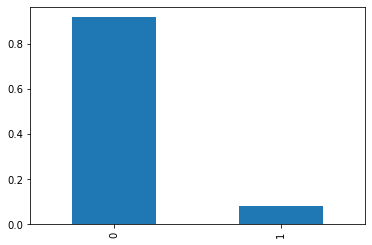

In [15]:
# This is a class-imbalanced dataset where only 10% of the customers are churned.
telecom_churn.churn.value_counts(normalize=True).plot.bar()
plt.show()

In [16]:
# Using 9th month data causes "target leakage" since it is the churn phase. So, remove all the columns related to 9th month.
cols_mnth_9 = [col for col in telecom_churn.columns if col.find('_9') != -1]
telecom_churn.drop(cols_mnth_9, axis=1, inplace=True)

In [17]:
# Define a function to check the data type, % of null values and number of unique values a column has in the dataset.
def create_dataset_overview():
    data = []
    for col in telecom_churn.columns:
        data.append({
            'feature': col,
            'data_type': str(telecom_churn[col].dtype),
            'null_values': telecom_churn[col].isnull().sum(),
            'null_values (in %)': round(100*(telecom_churn[col].isnull().sum() / len(telecom_churn)), 2),
            'num_of_unq_values': telecom_churn[col].nunique()
        })
    df = pd.DataFrame(columns=['feature', 'data_type', 'null_values', 'null_values (in %)', 'num_of_unq_values'], data=data)
    df.sort_values(inplace=True, by='null_values')
    return df

In [18]:
# Define a function to get the missing values in the dataset.
def check_missing_values():
    overview_df = create_dataset_overview()
    pd.set_option('display.max_rows', len(overview_df))
    return overview_df[overview_df.null_values > 0]
check_missing_values()

,feature,data_type,null_values,null_values (in %),num_of_unq_values
6,last_date_of_month_7,object,27,0.09,1
110,date_of_last_rech_6,object,73,0.24,30
111,date_of_last_rech_7,object,98,0.33,31
7,last_date_of_month_8,object,165,0.55,1
3,std_og_t2o_mou,float64,224,0.75,1
2,loc_og_t2o_mou,float64,224,0.75,1
4,loc_ic_t2o_mou,float64,224,0.75,1
27,loc_og_t2m_mou_7,float64,537,1.79,15674
87,std_ic_t2o_mou_7,float64,537,1.79,1
84,std_ic_t2f_mou_7,float64,537,1.79,2019


### Data Cleanup
- Removing unwanted features which doesn't contribute to analysis where,
    - Column having only 1 unique value - Derive new metric if required like date/month from date columns like "last_date_of_month_6" where the only value present is "6/30/2014".
- Handle missing values in both column and row level
    - If a customer has not used a service, impute the missing values with 0.
    - For an observation, if majority of the column values are missing, remove it.
- Outlier treatment

In [19]:
# Check if ALL the column values in any of the rows are empty. If found, those rows are removed.
telecom_churn[telecom_churn.isnull().all(axis=1)]

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,total_rech_amt_good,total_rech_amt_action,churn


In [20]:
# Check whether ANY of the rows are having missing values > 80%. If found, those rows are removed.
telecom_churn[100*(telecom_churn.isnull().sum(axis=1)/telecom_churn.shape[1]) > 80]

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,total_rech_amt_good,total_rech_amt_action,churn


In [21]:
# Majority of the columns which are missing are based on the customer usage (mou). Impute "0" for the missing values since the 
# customer has not used the service.
numerical_cols = telecom_churn.select_dtypes(include='number').columns

mou_cols = [mou_col for mou_col in numerical_cols if mou_col.lower().find('mou') != -1]
telecom_churn[mou_cols] = telecom_churn[mou_cols].fillna(0, axis=1)

# Even the incoming and outgoing columns can be imputed with "0" which indicates the customer has not made/received any calls.
ic_og_cols = ['ic_others_6', 'ic_others_7', 'ic_others_8', 'og_others_6', 'og_others_7', 'og_others_8']
telecom_churn[ic_og_cols] = telecom_churn[ic_og_cols].fillna(0, axis=1)

In [22]:
# Columns related to last date of a month are having only one value in the entire dataset. Impute the missing values for those
# columns with it's respective mode value.
for last_date_col in telecom_churn.columns:
    if last_date_col.lower().find('last_date') != -1:
        telecom_churn[last_date_col].fillna(telecom_churn[last_date_col].mode()[0], axis=0, inplace=True)

In [23]:
# Categorical columns with higher missing value percentage has to be imputed with a different category (-1).
cols_to_impute = ['night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8', 'fb_user_6', 'fb_user_7', 'fb_user_8']
telecom_churn[cols_to_impute] = telecom_churn[cols_to_impute].fillna(-1, axis=1)

In [24]:
check_missing_values()

,feature,data_type,null_values,null_values (in %),num_of_unq_values
110,date_of_last_rech_6,object,73,0.24,30
111,date_of_last_rech_7,object,98,0.33,31
112,date_of_last_rech_8,object,583,1.94,31
117,date_of_last_rech_data_7,object,12944,43.15,31
135,arpu_3g_7,float64,12944,43.15,6213
138,arpu_2g_7,float64,12944,43.15,5420
134,arpu_3g_6,float64,13245,44.15,6330
137,arpu_2g_6,float64,13245,44.15,5776
116,date_of_last_rech_data_6,object,13245,44.15,30
136,arpu_3g_8,float64,14048,46.83,6010


In [25]:
# It can be noticed that for ARPU, the min value is negative. One possible reason could be that, even though the customer
# doesn't recharge, they can still be using the service (atleast incoming) which is a overhead for the service provider.
# Setting up and fueling network towers takes a huge investment cost and if the customer uses the service without recharging,
# it's actually loss to the service provider. So, the ARPU value could be negative.
numerical_cols = telecom_churn.select_dtypes(include='number').columns
arpu_cols = [arpu_col for arpu_col in numerical_cols if arpu_col.lower().find('arpu') != -1]
telecom_churn[arpu_cols].describe()

,arpu_6,arpu_7,arpu_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8
count,30001.000000,30001.000000,30001.000000,16756.000000,17057.000000,15953.000000,16756.000000,17057.000000,15953.000000
mean,558.490824,560.782203,508.597957,119.974696,120.695809,118.050972,113.585859,113.801227,109.817427
std,460.640461,479.776947,501.961981,226.092738,229.575385,218.941369,201.792701,206.066861,195.348610
min,-2258.709000,-2014.045000,-945.808000,-30.280000,-26.040000,-24.490000,-15.320000,-15.480000,-24.430000
25%,309.865000,309.826000,231.473000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000
50%,481.694000,480.943000,427.585000,15.480000,12.950000,10.020000,26.915000,24.000000,19.900000
75%,699.943000,698.315000,661.491000,177.787500,180.040000,179.490000,168.517500,166.910000,157.190000
max,27731.088000,35145.834000,33543.624000,6362.280000,4980.900000,3716.900000,6433.760000,4809.360000,3467.170000


In [26]:
# Impute ARPU columns with MICE imputer.
mice_imputer = IterativeImputer()
telecom_churn[arpu_cols] = mice_imputer.fit_transform(telecom_churn[arpu_cols])
telecom_churn.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,total_rech_amt_good,total_rech_amt_action,churn
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,197.385,214.816,213.803,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.16,0.00,0.00,4.13,0.00,0.00,1.15,0.00,0.00,5.44,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,5.44,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,4,3,2,252,252,252,6/21/2014,7/16/2014,8/8/2014,252,252,252,6/21/2014,7/16/2014,8/8/2014,252.0,252.0,252.0,0.0,0.0,0.0,1.0,1.0,1.0,30.13,1.32,5.75,83.57,150.76,109.61,212.170000,212.170000,212.170000,212.170000,212.170000,212.170000,0.0,0.0,0.0,0,0,0,0,0,0,1,1,1,0,0,0,1.0,1.0,1.0,968,30.40,0.00,101.20,3.58,559.0,504.0,1
7,7000701601,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,1069.180,1349.850,3171.480,57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.0,0.0,0.00,422.16,533.91,255.79,4.30,23.29,12.01,49.89,31.76,49.14,6.66,20.08,16.68,0.0,0.0,0.0,60.86,75.14,77.84,0.0,0.18,10.01,4.5,0.0,6.50,0.0,0.0,0.0,487.53,609.24,350.16,58.14,32.26,27.31,217.56,221.49,121.19,152.16,101.46,39.53,427.88,355.23,188.04,36.89,11.83,30.39,91.44,126.99,141.33,52.19,34.24,22.21,0.0,0.0,0.0,180.54,173.08,193.94,626.46,558.04,428.74,0.21,0.0,0.0,2.06,14.53,31.59,15.74,15.19,15.14,5,5,7,1580,790,1580,6/27/2014,7/25/2014,8/26/2014,0,0,779,NaN,NaN,NaN,0

In [27]:
check_missing_values()

,feature,data_type,null_values,null_values (in %),num_of_unq_values
110,date_of_last_rech_6,object,73,0.24,30
111,date_of_last_rech_7,object,98,0.33,31
112,date_of_last_rech_8,object,583,1.94,31
117,date_of_last_rech_data_7,object,12944,43.15,31
116,date_of_last_rech_data_6,object,13245,44.15,30
118,date_of_last_rech_data_8,object,14048,46.83,31


### Fixing datatypes for date columns

In [28]:
date_cols = [date_col for date_col in telecom_churn.columns if date_col.lower().find('date') != -1]
for date_col in date_cols:
    telecom_churn[date_col] = pd.to_datetime(telecom_churn[date_col])

In [29]:
# Create a derived metric "recharge before end of month (eom)" using the date variables.
# For calls recharge
telecom_churn['rech_before_eom_6'] = (telecom_churn['last_date_of_month_6'] - telecom_churn['date_of_last_rech_6']).dt.days
telecom_churn['rech_before_eom_7'] = (telecom_churn['last_date_of_month_7'] - telecom_churn['date_of_last_rech_7']).dt.days
telecom_churn['rech_before_eom_8'] = (telecom_churn['last_date_of_month_8'] - telecom_churn['date_of_last_rech_8']).dt.days
# For data recharge
telecom_churn['data_rech_before_eom_6'] = (telecom_churn['last_date_of_month_6'] - telecom_churn['date_of_last_rech_data_6']).dt.days
telecom_churn['data_rech_before_eom_7'] = (telecom_churn['last_date_of_month_7'] - telecom_churn['date_of_last_rech_data_7']).dt.days
telecom_churn['data_rech_before_eom_8'] = (telecom_churn['last_date_of_month_8'] - telecom_churn['date_of_last_rech_data_8']).dt.days

telecom_churn.drop(date_cols, axis=1, inplace=True)

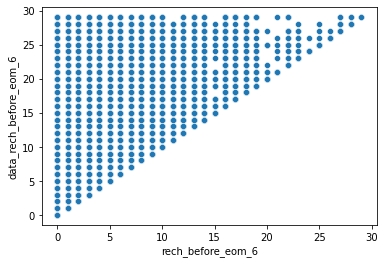

In [30]:
sns.scatterplot(x='rech_before_eom_6', y='data_rech_before_eom_6', data=telecom_churn)
plt.show()

**Observations:**
- 0 indicates a customer has recharged towards the end of the month and 30 indicates customer has recharged at the beginning of the month since we are taking difference between last day of the month and the day of recharge.
- More likely people will recharge for data services rather than services for calls.

In [31]:
# The correlation between call and data recharge is not strong enough.
telecom_churn[['rech_before_eom_8', 'data_rech_before_eom_8']].corr()

,rech_before_eom_8,data_rech_before_eom_8
rech_before_eom_8,1.000000,0.416762
data_rech_before_eom_8,0.416762,1.000000


In [32]:
check_missing_values()

,feature,data_type,null_values,null_values (in %),num_of_unq_values
157,rech_before_eom_6,float64,73,0.24,30
158,rech_before_eom_7,float64,98,0.33,31
159,rech_before_eom_8,float64,583,1.94,31
161,data_rech_before_eom_7,float64,12944,43.15,31
160,data_rech_before_eom_6,float64,13245,44.15,30
162,data_rech_before_eom_8,float64,14048,46.83,31


In [33]:
# Impute call recharge columns with 0 as it is the most frequent value and since the missing values are ~1%. 
call_rech_cols = ['rech_before_eom_6', 'rech_before_eom_7', 'rech_before_eom_8']
telecom_churn[call_rech_cols] = telecom_churn[call_rech_cols].fillna(0, axis=1)

# Impute data recharge columns with -1 since the missing values are higher. 
data_rech_cols = ['data_rech_before_eom_6', 'data_rech_before_eom_7', 'data_rech_before_eom_8']
telecom_churn[data_rech_cols] = telecom_churn[data_rech_cols].fillna(-1, axis=1)

In [34]:
# All the missing values are handled.
check_missing_values()

,feature,data_type,null_values,null_values (in %),num_of_unq_values


### Column Operations:
- Remove columns which have only one unique value in the entire dataset - This indicates no variance in the feature.
- Remove columns which have unique values for all observations.
- Rename relevant columns.

In [35]:
overview_df = create_dataset_overview()
overview_df.sort_values(by='num_of_unq_values', ascending=False)

,feature,data_type,null_values,null_values (in %),num_of_unq_values
0,mobile_number,int64,0,0.0,30001
6,arpu_7,float64,0,0.0,29084
5,arpu_6,float64,0,0.0,29072
7,arpu_8,float64,0,0.0,28073
60,total_og_mou_7,float64,0,0.0,23684
59,total_og_mou_6,float64,0,0.0,23519
61,total_og_mou_8,float64,0,0.0,22316
12,offnet_mou_7,float64,0,0.0,21263
11,offnet_mou_6,float64,0,0.0,21220
13,offnet_mou_8,float64,0,0.0,20163


In [36]:
cols_to_drop = []
for col in telecom_churn.columns:
    unq_vals = telecom_churn[col].nunique()
    if unq_vals == 1 or unq_vals == len(telecom_churn):
        cols_to_drop.append(col)
telecom_churn.drop(cols_to_drop, axis=1, inplace=True)

In [37]:
# Rename the columns for consistency.
telecom_churn.rename({
    'jun_vbc_3g': 'vbc_3g_6',
    'jul_vbc_3g': 'vbc_3g_7',
    'aug_vbc_3g': 'vbc_3g_8'
}, axis=1, inplace=True)

In [38]:
# Check the number of observations and columns left after treating missing values.
telecom_churn.shape

(30001, 152)

In [39]:
# Check for correlations between input variables.
telecom_churn.corr()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,vbc_3g_8,vbc_3g_7,vbc_3g_6,sep_vbc_3g,total_rech_amt_good,total_rech_amt_action,churn,rech_before_eom_6,rech_before_eom_7,rech_before_eom_8,data_rech_before_eom_6,data_rech_before_eom_7,data_rech_before_eom_8
arpu_6,1.000000,0.671732,0.612617,0.342438,0.216136,0.186807,0.509280,0.339350,0.285100,0.126884,0.083484,0.090363,0.196086,0.143261,0.124994,0.167352,0.127683,0.123732,0.332207,0.245092,0.218150,0.139434,0.114368,0.104302,0.047680,0.010017,0.011393,0.328978,0.246204,0.223301,0.274093,0.161528,0.133795,0.301575,0.181414,0.139780,0.066751,0.053564,0.043895,0.385851,0.230380,0.182037,0.466898,0.420753,0.413504,0.122743,0.068491,0.044582,0.054782,0.024347,0.015490,0.554510,0.363276,0.301856,0.082855,0.062961,0.062838,0.188556,0.149218,0.124188,0.051510,0.039208,0.037365,0.181866,0.142514,0.124191,0.088103,0.061598,0.056880,0.098775,0.065714,0.062874,0.034451,0.032583,0.022957,0.125126,0.085687,0.079334,0.225987,0.169024,0.150749,0.031356,-0.034186,-0.011741,0.103090,0.063193,0.070653,0.016183,0.023868,0.012284,0.349709,0.136098,0.119406,0.337983,0.261993,0.284518,0.266656,0.207282,0.199304,0.072714,-0.021877,0.025203,-0.165470,-0.208538,-0.161828,0.090485,0.020223,0.035060,-0.062580,-0.098980,-0.077949,0.152507,0.070184,0.084675,0.458963,0.211492,0.235368,0.419056,0.169498,0.203456,-0.110288,-0.192870,-0.120593,-0.039073,-0.084189,-0.061430,-0.158359,-0.193927,-0.152069,0.176436,0.081091,0.103661,-0.002555,-0.025233,-0.017509,-0.122195,-0.203611,-0.137702,0.041451,0.058547,0.055172,0.112462,0.045053,0.368357,0.207462,0.067624,-0.172465,-0.037434,-0.075205,-0.072829,-0.097054,-0.069512
arpu_7,0.671732,1.000000,0.759858,0.211608,0.320818,0.270330,0.351713,0.490176,0.395668,0.092501,0.093692,0.093961,0.133520,0.179894,0.152217,0.106674,0.157926,0.135348,0.215457,0.303201,0.256019,0.112066,0.140968,0.121890,0.009198,0.040485,0.032706,0.213501,0.304529,0.255867,0.166621,0.260775,0.219911,0.203737,0.307786,0.239066,0.051743,0.070678,0.053822,0.248495,0.381714,0.305135,0.416974,0.508862,0

### EDA: Exploratory Data Analysis
#### Outlier Treatment:
- Use flooring (5th percentile) & capping (95th percentile) method to handle outliers

In [40]:
# Lot of columns are having outliers.
telecom_churn.describe()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,vbc_3g_8,vbc_3g_7,vbc_3g_6,sep_vbc_3g,total_rech_amt_good,total_rech_amt_action,churn,rech_before_eom_6,rech_before_eom_7,rech_before_eom_8,data_rech_before_eom_6,data_rech_before_eom_7,data_rech_before_eom_8
count,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.00000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.0000

In [41]:
# Define a function which creates box plots for numeric columns.
def num_col_box_plot(df=telecom_churn, fig_height=80):
    num_cols = df.select_dtypes(include='number')
    num_cols_per_row = 5
    num_rows = int(np.ceil(len(num_cols.columns)/num_cols_per_row))
    fig_num = 0
    plt.figure(figsize=(15,fig_height))
    for col in num_cols:
        fig_num += 1
        plt.subplot(num_rows, num_cols_per_row, fig_num)
        num_cols[col].plot.box()
    plt.show()

# Define a function which creates distribution plots for numeric columns.
def num_col_dist_plot(df=telecom_churn):
    num_cols = df.select_dtypes(include='number')
    num_cols_per_row = 5
    num_rows = int(np.ceil(len(num_cols.columns)/num_cols_per_row))
    fig_num = 0
    plt.figure(figsize=(15,25))
    for col in num_cols:
        fig_num += 1
        plt.subplot(num_rows, num_cols_per_row, fig_num)
        num_cols[col].plot.density()
        plt.xlabel(col)
    plt.show()

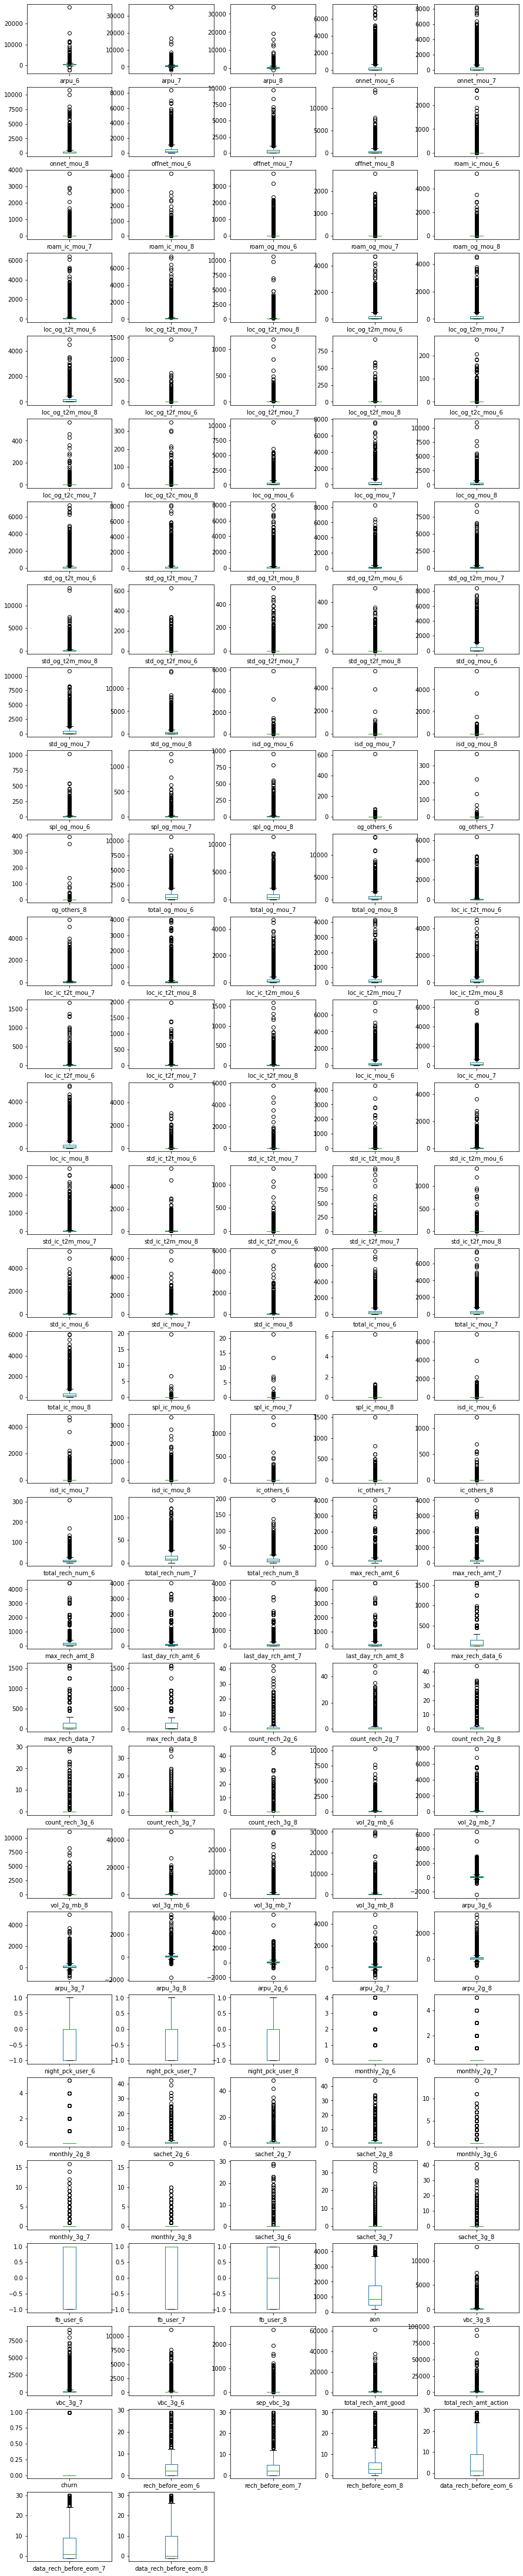

In [42]:
num_col_box_plot()

In [43]:
# Handle outliers only for the columns which is having >75% of observations between 5th and 95th percentile since we are using
# flooring and capping method. Most of the values in a column will be floored/capped if we don't consider 75% of data between 
# upper and lower ends which surely changes majority of the data and leads to a biased model.
lower_prcntle = 5
upper_prcntle = 100 - lower_prcntle
def get_upper_lower_bound_obs():
    cols_within_range_75 = []
    low_variance_cols = []
    
    for num_col in telecom_churn.drop('churn', axis=1): # Skip "churn" column since that is the target column.
        # Considering columns which are having > 50 unique values to treat outliers because the data is continuous.
        # Few of the columns which are having unique values < 50 includes nominal/ordinal categories.
        if telecom_churn[num_col].nunique() <= 50:
            continue
        obs_within_lmts = telecom_churn[(telecom_churn[num_col] > telecom_churn[num_col].quantile(lower_prcntle/100)) & 
                                  (telecom_churn[num_col] < telecom_churn[num_col].quantile(upper_prcntle/100))]
        prcnt_of_obs = 100*obs_within_lmts.shape[0]/telecom_churn.shape[0]
        if prcnt_of_obs < 30:
            low_variance_cols.append(num_col)
        elif prcnt_of_obs > 75:
            cols_within_range_75.append(num_col)
        print('There are {}% of observations between {}th percentile and {}th percentile for the column {}.'
              .format(round(prcnt_of_obs, 2), lower_prcntle, upper_prcntle, num_col))
    return low_variance_cols, cols_within_range_75

low_variance_cols, cols_within_range_75 = get_upper_lower_bound_obs()

There are 89.99% of observations between 5th percentile and 95th percentile for the column arpu_6.
There are 89.99% of observations between 5th percentile and 95th percentile for the column arpu_7.
There are 89.99% of observations between 5th percentile and 95th percentile for the column arpu_8.
There are 86.34% of observations between 5th percentile and 95th percentile for the column onnet_mou_6.
There are 86.16% of observations between 5th percentile and 95th percentile for the column onnet_mou_7.
There are 82.94% of observations between 5th percentile and 95th percentile for the column onnet_mou_8.
There are 89.99% of observations between 5th percentile and 95th percentile for the column offnet_mou_6.
There are 89.99% of observations between 5th percentile and 95th percentile for the column offnet_mou_7.
There are 86.98% of observations between 5th percentile and 95th percentile for the column offnet_mou_8.
There are 16.18% of observations between 5th percentile and 95th percentile 

There are 89.31% of observations between 5th percentile and 95th percentile for the column max_rech_amt_6.
There are 88.86% of observations between 5th percentile and 95th percentile for the column max_rech_amt_7.
There are 87.48% of observations between 5th percentile and 95th percentile for the column max_rech_amt_8.
There are 77.72% of observations between 5th percentile and 95th percentile for the column last_day_rch_amt_6.
There are 74.47% of observations between 5th percentile and 95th percentile for the column last_day_rch_amt_7.
There are 67.0% of observations between 5th percentile and 95th percentile for the column last_day_rch_amt_8.
There are 44.99% of observations between 5th percentile and 95th percentile for the column vol_2g_mb_6.
There are 45.52% of observations between 5th percentile and 95th percentile for the column vol_2g_mb_7.
There are 41.05% of observations between 5th percentile and 95th percentile for the column vol_2g_mb_8.
There are 30.44% of observations be

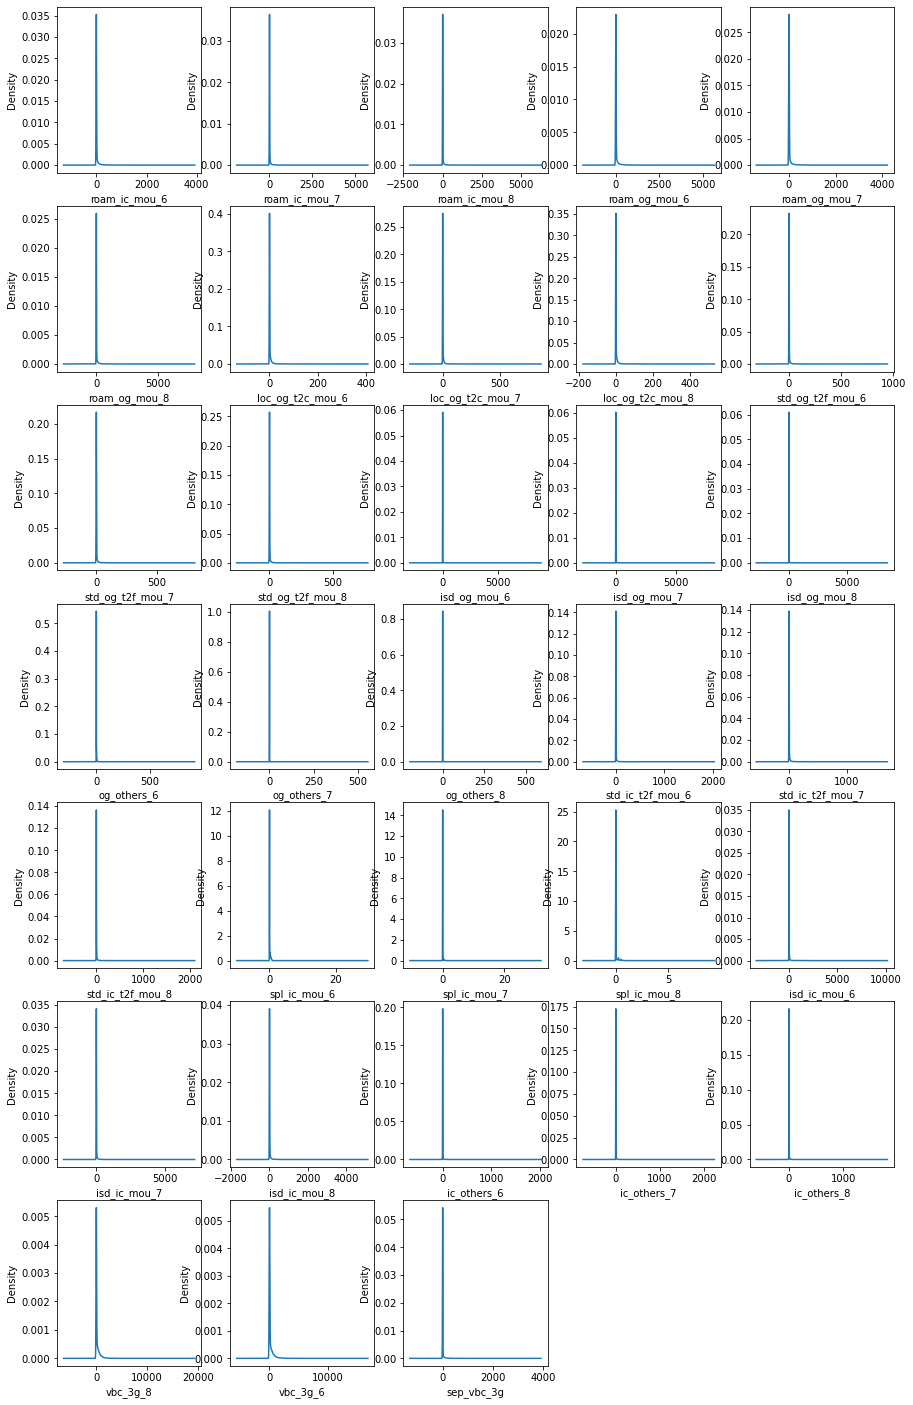

In [44]:
# It's clear from the plot that values are centered around mean and doesn't have variance. Remove these columns as they don't
# contribute much for analysis.
num_col_dist_plot(telecom_churn[low_variance_cols])
telecom_churn.drop(low_variance_cols, axis=1, inplace=True)

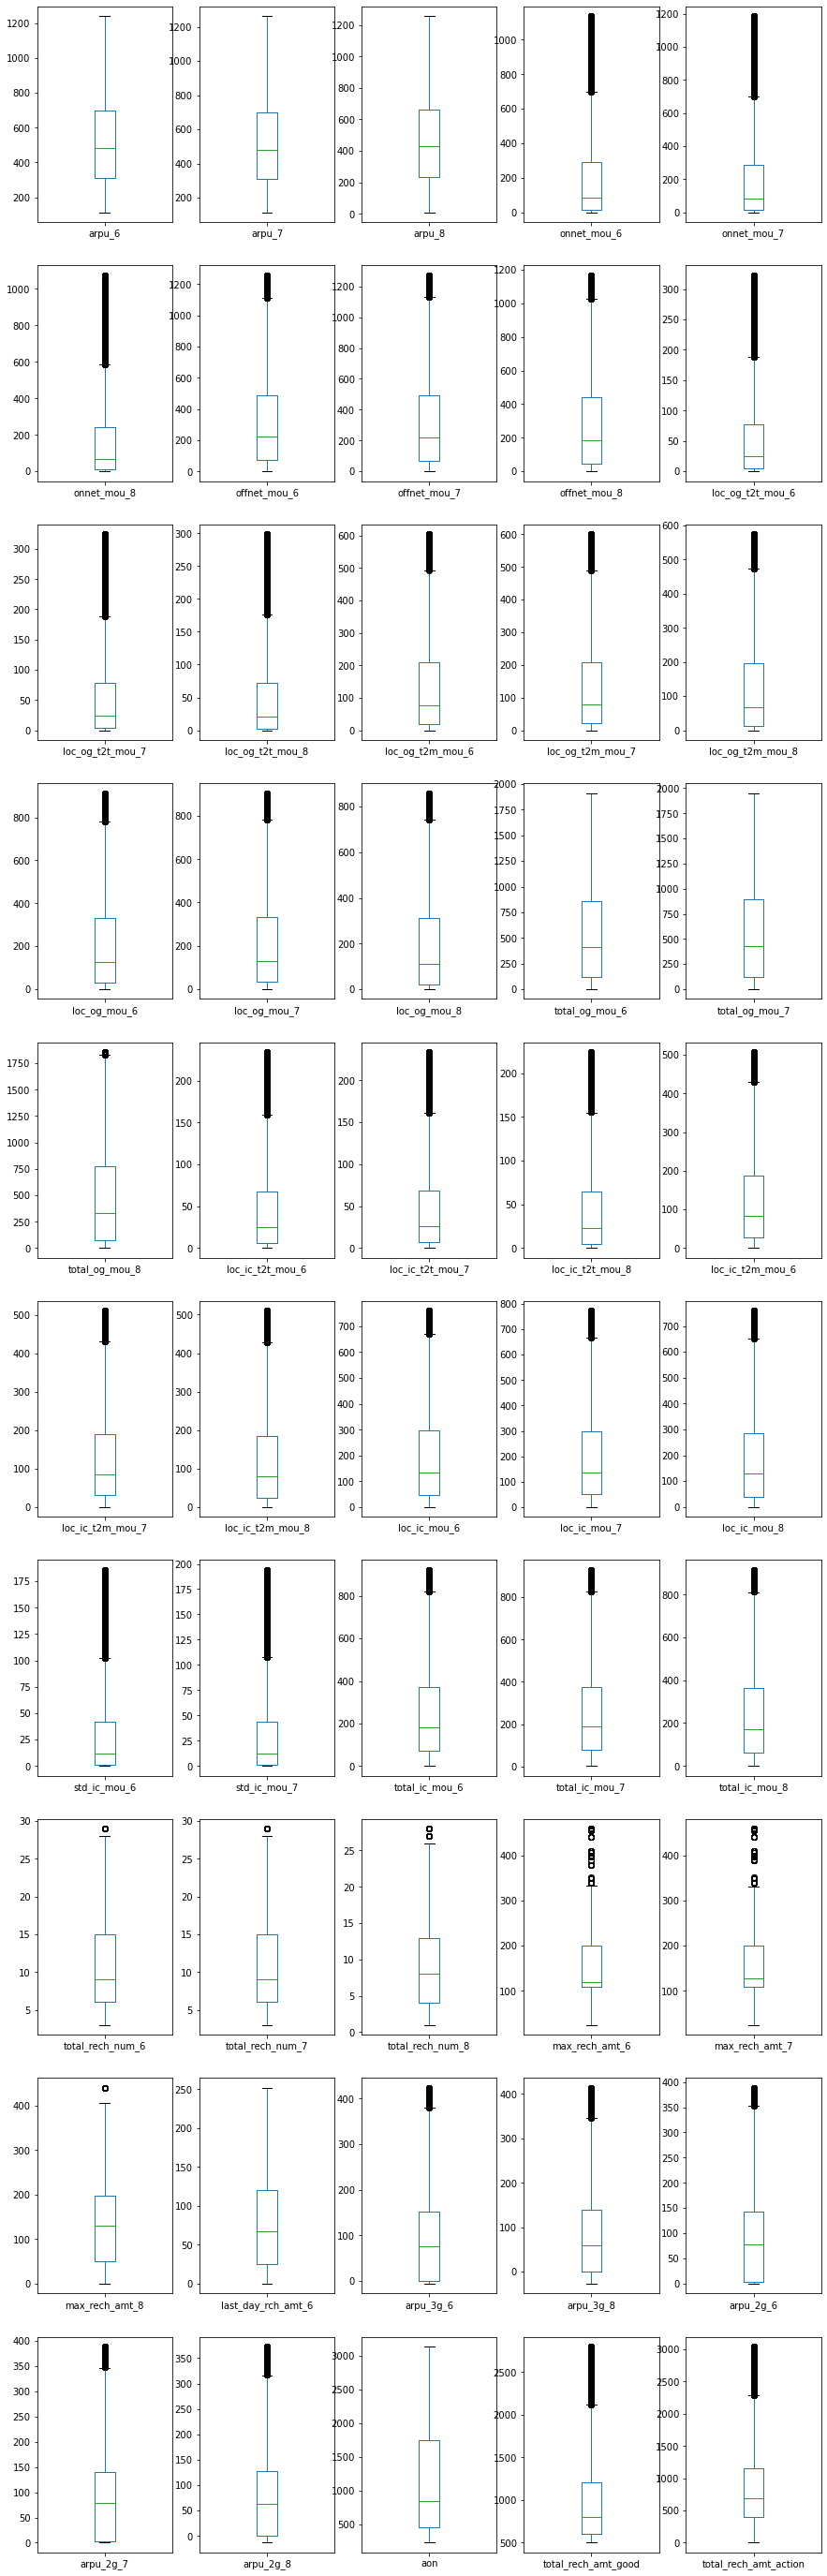

In [45]:
# Define a function to handle outliers based on flooring and capping.
def floor_cap_outliers(low, high, val):
    if val < low:
        return low
    elif val > high:
        return high
    else:
        return val

for num_col in cols_within_range_75:
    lower_prnctle_val = telecom_churn[num_col].quantile(lower_prcntle/100)
    upper_prcntle_val = telecom_churn[num_col].quantile(upper_prcntle/100)
    telecom_churn[num_col] = telecom_churn.apply(
        lambda row: floor_cap_outliers(lower_prnctle_val, upper_prcntle_val, row[num_col]),
        axis=1
    )

# Verify columns after handling outliers
num_col_box_plot(telecom_churn[cols_within_range_75], fig_height=50)

In [46]:
telecom_churn.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,vbc_3g_7,total_rech_amt_good,total_rech_amt_action,churn,rech_before_eom_6,rech_before_eom_7,rech_before_eom_8,data_rech_before_eom_6,data_rech_before_eom_7,data_rech_before_eom_8
0,197.385,214.816,213.803,0.00,0.00,0.00,0.21,0.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.16,0.00,0.31,4.13,0.00,0.00,1.15,0.56,1.15,5.44,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.26,2.44,5.44,4.0,3.0,2.0,252.0,252.0,252.0,252.0,252,252,252.0,252.0,252.0,0.0,0.0,0.0,1.0,1.0,1.0,30.13,1.32,5.75,83.57,150.76,109.61,212.170000,212.170000,212.17000,212.170000,212.170000,212.170000,0.0,0.0,0.0,0,0,0,0,0,0,1,1,1,0,0,0,1.0,1.0,1.0,968.0,0.00,559.0,504.0,1,9.0,15.0,23.0,9.0,15.0,23.0
7,1069.180,1261.272,1255.019,57.84,54.68,52.29,453.43,567.16,325.91,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,422.16,533.91,255.79,4.30,23.29,12.01,49.89,31.76,49.14,60.86,75.14,77.84,4.5,0.0,6.50,487.53,609.24,350.16,58.14,32.26,27.31,217.56,221.49,121.19,152.16,101.46,39.53,427.88,355.23,188.04,36.89,11.83,30.39,91.44,126.99,141.33,180.54,173.08,193.94,626.46,558.04,428.74,5.0,5.0,7.0,459.0,459.0,440.0,0.0,0,779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,30.047255,57.038955,414.43000,23.144072,51.327379,372.929067,-1.0,-1.0,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,-1.0,-1.0,-1.0,802.0,19.38,1185.0,3043.0,1,3.0,6.0,5.0,-1.0,-1.0,-1.0
8,378.721,492.223,137.362,413.69,351.03,35.08,94.66,80.63,136.48,297.13,217.59,12.49,80.96,70.58,50.54,0.00,0.00,0.00,378.09,288.18,63.04,116.56,133.43,22.58,13.69,10.04,75.69,130.26,143.48,98.28,0.0,0.0,10.23,508.36,431.66,171.56,23.84,9.84,0.31,57.58,13.98,15.48,0.00,0.00,0.00,81.43,23.83,15.79,0.00,0.58,0.10,22.43,4.08,0.65,22.43,4.66,0.75,103.86,28.49,16.54,19.0,21.0,14.0,90.0,154.0,30.0,50.0,0,10,0.0,154.0,23.0,0.0,2.0,3.0,0.0,0.0,0.0,0.00,356.00,0.03,0.00,750.95,11.94,16.704811,0.000000,19.83000,13.983879,0.000000,0.000000,-1.0,0.0,0.0,0,1,0,0,1,3,0,0,0,0,0,0,-1.0,1.0,1.0,315.0,910.65,696.0,327.0,0,5.0,0.0,1.0,-1.0,0.0,8.0
21,514.453,597.753,637.760,102.41,132.11,85.14,757.93,896.68,983.39,4.48,6.16,23.34,91.81,87.93,104.81,0.75,0.00,1.58,97.04,94.09,129.74,97.93,125.94,61.79,665.36,808.74,876.99,763.29,934.69,938.79,0.0,0.0,0.00,860.34,1028.79,1068.54,2.48,10.19,19.54,118.23,74.63,129.16,4.61,2.84,10.39,125.33,87.68,159.11,14.06,5.98,0.18,67.69,38.23,101.74,81.76,44.21,101.93,

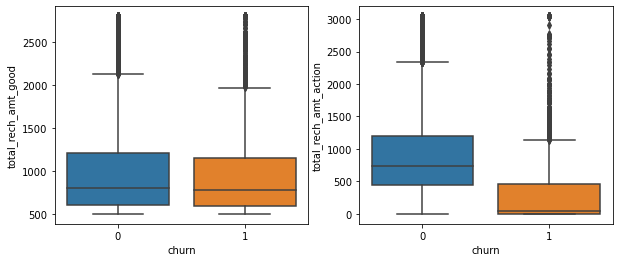

In [47]:
# Define a function to create plots w.r.t recharge amount.
def draw_bivariate_plots_recharge_amount(df=telecom_churn):
    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    sns.boxplot(x='churn', y='total_rech_amt_good', data=df)
    plt.subplot(122)
    sns.boxplot(x='churn', y='total_rech_amt_action', data=df)
    plt.show()
draw_bivariate_plots_recharge_amount()

**Observations**:
- When the recharge amount is compared between good and the action phase, it's clear that when a customer is in action phase, the amount of recharge has drastically reduced.

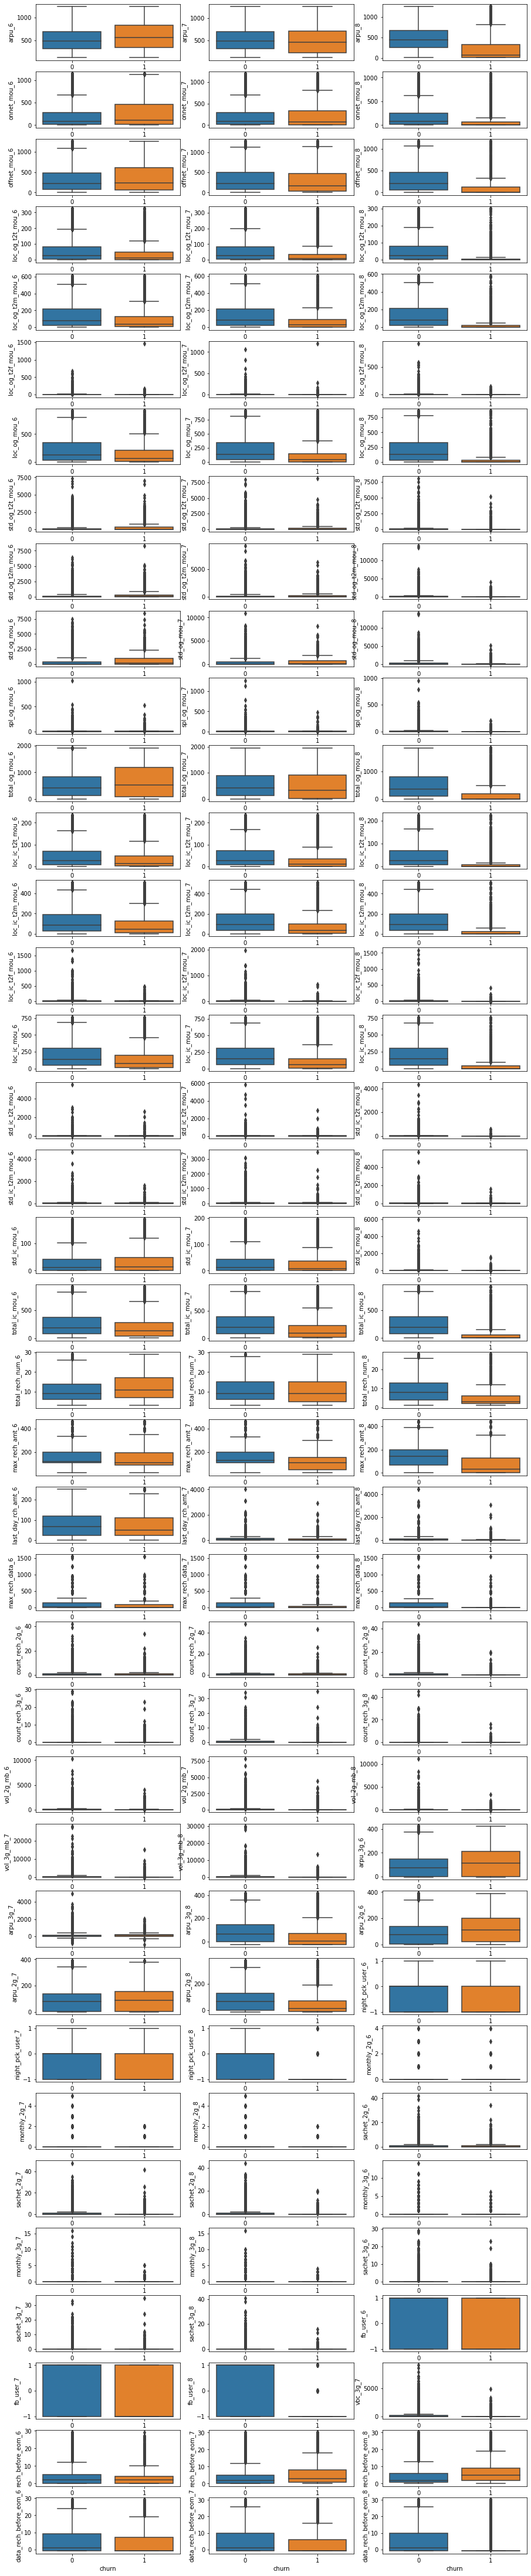

In [48]:
# Define a function to create plots w.r.t MOU.
def draw_bivariate_plots_mou(df=telecom_churn, fig_height=80):
    num_cols = df.select_dtypes(include='number')
    compare_variables = []
    for col in num_cols.columns:
        if ((col.find('_6') != -1) | (col.find('_7') != -1) | (col.find('_8') != -1)):
            compare_variables.append(col)
    compare_variables.remove('vol_3g_mb_6')
    
    num_cols_per_row = 3
    num_rows = int(np.ceil(len(compare_variables)/num_cols_per_row))
    fig_num = 0
    plt.figure(figsize=(15,fig_height))
    for col in compare_variables:
        fig_num += 1
        plt.subplot(num_rows, num_cols_per_row, fig_num)
        sns.boxplot(x='churn', y=col, data=df)
    plt.show()

# Understanding the relationship between all the predictor variables and the churn variable
draw_bivariate_plots_mou()

**Observations:**
- The good phase indicates 6th and 7th month and the action phase indicates 8th month respectively.
- The ARPU has declined in action phase when compared to good phase.
- The recharge amount for data and for calls are less for in action phase when compared to good phase.
- The count columns doesn't clearly show box plots which indicates, the majority number of customers hasn't recharged for particular months respectively.
- The total incoming calls are drastically declined in action phase.
- The total outgoing calls are drastically declined in action phase.

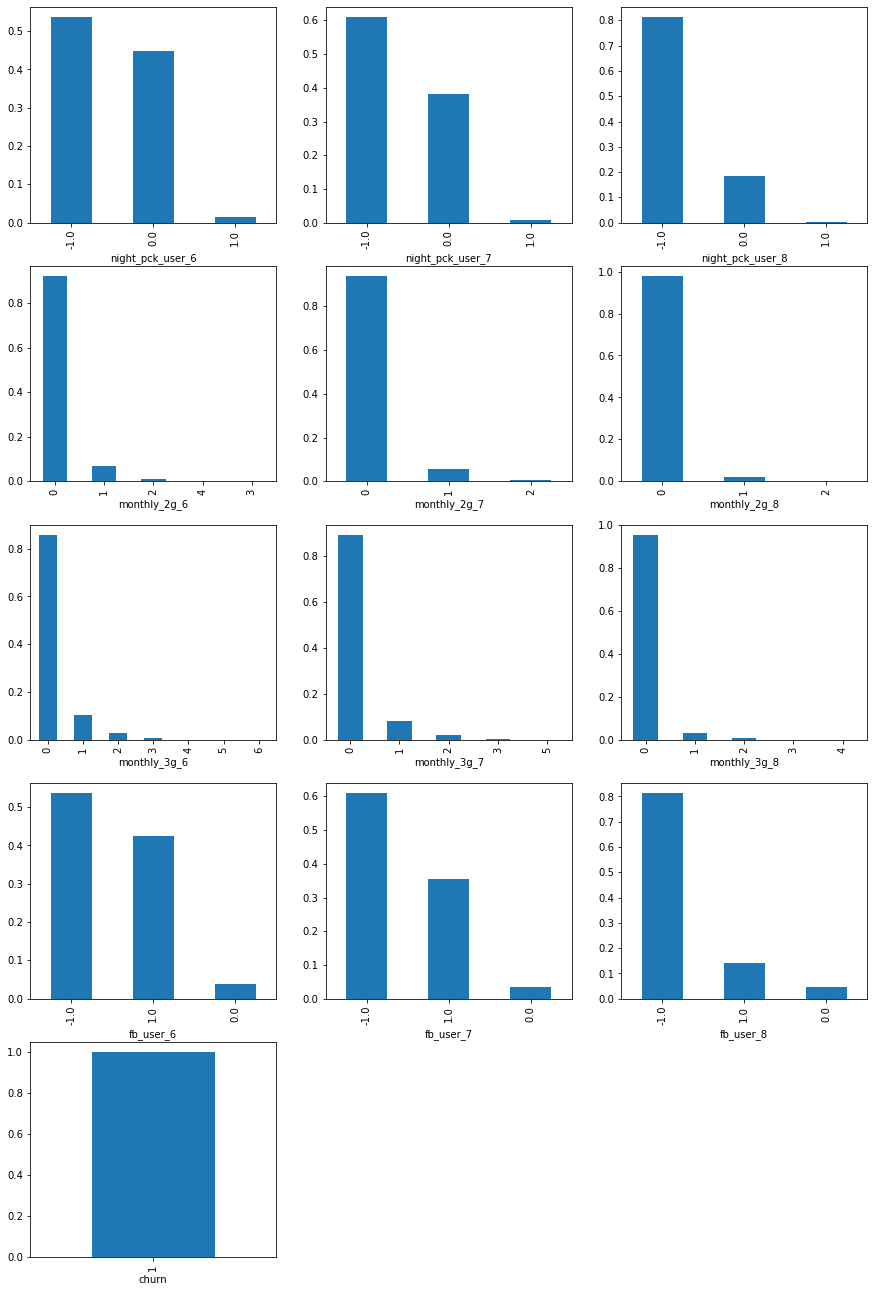

In [49]:
# Plots for numeric categories.
cat_cols = []
for col in telecom_churn:
    unq_val = telecom_churn[col].nunique()
    if (unq_val <= 15):
        cat_cols.append(col)
rows = round(len(cat_cols)/3) + 1
plt.figure(figsize=(15,23))
fig_num = 1
for col in cat_cols:
    plt.subplot(rows, 3, fig_num)
    telecom_churn[telecom_churn['churn'] == 1][col].value_counts(normalize=True).plot.bar()
    plt.xlabel(col)
    fig_num+=1
plt.show()

**Observations:**
- For users who are going to churn, usage of night pack or FB user packs drops.
- Also, for such users number of monthly data recharges drops.

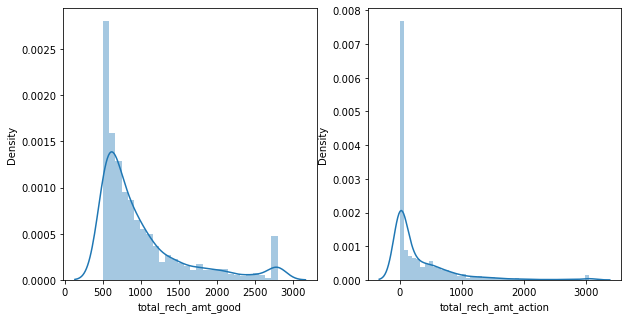

In [50]:
# Plot the distributions for recharge variables.
plt.figure(figsize=(10,5))
fig_num = 1

plt.subplot(121)
sns.distplot(telecom_churn[telecom_churn['churn'] == 1]['total_rech_amt_good'])
plt.xlabel('total_rech_amt_good')

plt.subplot(122)
sns.distplot(telecom_churn[telecom_churn['churn'] == 1]['total_rech_amt_action'])
plt.xlabel('total_rech_amt_action')
plt.show()

**Observations:** The total amount of recharge is higher in good phase when compared to action phase

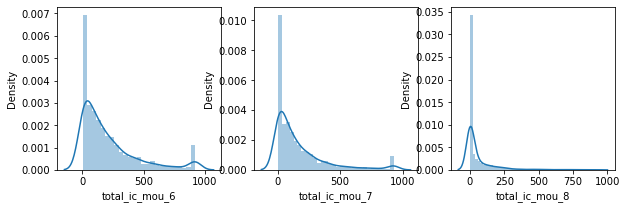

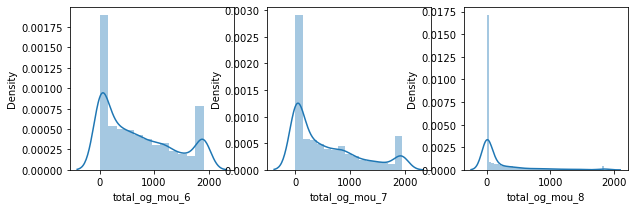

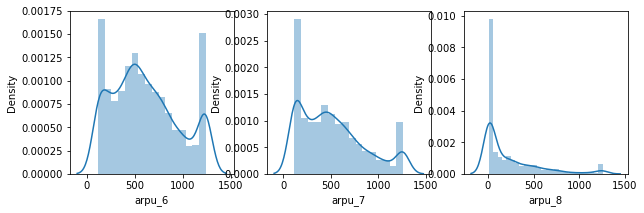

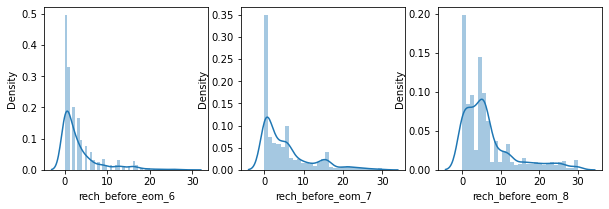

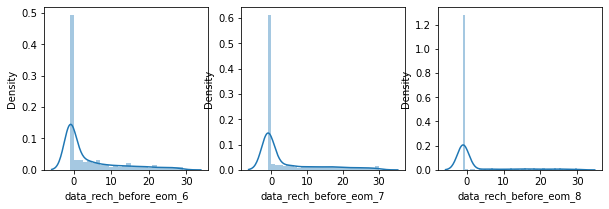

In [51]:
# Plot the distributions of the usage related variables.
plt.figure(figsize=(10,3))
for i in range (1,4):
    plt.subplot(1, 3, i)
    sns.distplot(telecom_churn[telecom_churn['churn'] == 1]['total_ic_mou_' + str(i + 5)])
plt.show()

plt.figure(figsize=(10,3))
for i in range (1,4):
    plt.subplot(1, 3, i)
    sns.distplot(telecom_churn[telecom_churn['churn'] == 1]['total_og_mou_' + str(i + 5)])
plt.show()

plt.figure(figsize=(10,3))
for i in range (1,4):
    plt.subplot(1, 3, i)
    sns.distplot(telecom_churn[telecom_churn['churn'] == 1]['arpu_' + str(i + 5)])
plt.show()


plt.figure(figsize=(10,3))
for i in range (1,4):
    plt.subplot(1, 3, i)
    sns.distplot(telecom_churn[telecom_churn['churn'] == 1]['rech_before_eom_' + str(i + 5)])
plt.show()


plt.figure(figsize=(10,3))
for i in range (1,4):
    plt.subplot(1, 3, i)
    sns.distplot(telecom_churn[telecom_churn['churn'] == 1]['data_rech_before_eom_' + str(i + 5)])
plt.show()

**Observations:**
- Here we can clearly see, for the users who are going to churn, recharge amount drops significantly during action phase.
- Also, we can see a clear trend in subsequent distribution plots as well.
- Incoming and out going call minutes are more centered towards zero in action phase which indicates the usage is dropping.
- Overall average revenue per user is dropping drastically.
- From the field 'Reacharge done before end of month' we can notice that customer who are going to churn, as months passes, they tend to not do full recharge at the start of the month but during the month as and when needed.
- Data rechage drops drastically as the months pass by.

### Handle class-imbalance data
Before handling the class-imbalance data,
- Split the data into train and test datasets.
- Scale the data using standard scaler.
- Use SMOTE as an oversampling technique to balance the training data.

In [52]:
X = telecom_churn.drop('churn', axis=1)
y = telecom_churn.churn
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
# Check the shape of the datasets after split
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(21000, 118) (21000,) (9001, 118) (9001,)


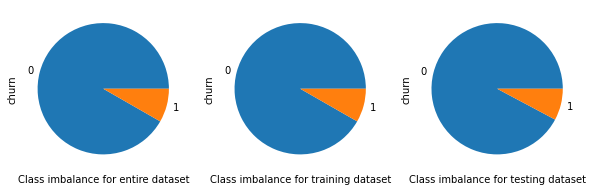

There is similar level of class imbalance for all kind of datasets.


In [53]:
plt.figure(figsize=(10, 5))
plt.subplot(131)
y_train.value_counts().plot.pie()
plt.xlabel('Class imbalance for entire dataset')
plt.subplot(132)
y_train.value_counts().plot.pie()
plt.xlabel('Class imbalance for training dataset')
plt.subplot(133)
y_test.value_counts().plot.pie()
plt.xlabel('Class imbalance for testing dataset')
plt.show()
print('There is similar level of class imbalance for all kind of datasets.')

In [54]:
# Scaling train dataset
scaler = StandardScaler()
X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
X_train.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,vbc_3g_7,total_rech_amt_good,total_rech_amt_action,rech_before_eom_6,rech_before_eom_7,rech_before_eom_8,data_rech_before_eom_6,data_rech_before_eom_7,data_rech_before_eom_8
65002,0.010612,0.344980,-1.420846,-0.575835,-0.497489,-0.677188,-0.943716,-0.925317,-0.920458,-0.309113,0.041789,-0.698486,-0.790931,-0.803166,-0.830008,-0.28234,-0.163258,-0.299793,-0.703478,-0.583229,-0.854788,-0.383975,-0.402443,-0.372613,-0.442330,-0.426982,-0.382480,-0.553881,-0.557448,-0.503115,-0.318102,-0.307041,-0.314388,-0.939696,-0.892274,-0.959993,-0.417695,-0.368725,-0.781214,-0.817741,-0.742762,-0.923572,-0.336231,-0.187589,-0.335106,-0.783212,-0.686842,-0.954041,-0.093874,-0.080154,-0.193299,-0.304538,-0.259991,-0.286797,-0.131166,-0.451835,-0.331625,-0.768303,-0.754933,-1.005630,-0.759417,-1.002376,-1.038414,0.411409,2.766751,-1.363704,1.476514,-0.702804,-0.640032,3.314393,3.284031,-0.650731,-0.499488,-0.514452,-0.480512,1.364708,0.440699,-0.321802,-0.329005,-0.316364,-0.340544,2.536611,1.321788,-0.37783,2.748841,1.660379,2.216586,2.783944,2.815720,1.760358,0.828664,0.816567,-1.040015,-0.401223,-0.408192,-0.377496,-0.426863,-0.444660,-0.418969,2.868758,1.179358,-0.33704,-0.212156,-0.204953,-0.18368,0.952408,0.940181,-1.032856,-0.144977,1.717411,0.702019,-1.166468,0.311323,2.467213,-0.419248,0.480812,1.289164,-0.720541
67088,-0.250403,-0.064961,-0.198831,0.000856,-0.280109,-0.026080,1.334105,1.054870,-0.104991,-0.158881,-0.088649,-0.255029,-0.341060,-0.359417,-0.360140,-0.28234,-0.286201,-0.299793,-0.356553,-0.345857,-0.396708,0.036784,-0.250661,-0.216104,1.325354,0.648283,-0.158632,0.908486,0.273982,-0.250016,-0.318102,-0.307041,-0.314388,0.851471,0.172140,-0.456001,-0.551844,0.144801,-0.391409,0.156792,-0.104525,0.239099,-0.328491,-0.320467,-0.315306,-0.173812,-0.143429,-0.057842,-0.182779,-0.174364,-0.003626,0.044465,0.217636,-0.252412,-0.004382,0.367235,-0.203740,-0.229648,-0.135541,-0.189237,-0.473993,0.398858,0.771906,-0.335429,-0.347858,-0.174330,0.305202,-0.248476,-0.501314,-0.684342,-0.693914,-0.650731,-0.499488,-0.514452,-0.480512,-0.366004,-0.353557,-0.321802,-0.391678,-0.379081,-0.340544,-0.363854,-0.398893,-0.37783,-0.033977,0.028829,-0.016542,-0.027656,0.156891,-0.001152,-1.093777,-1.115374,-1.040015,-0.401223,-0.408192,-0.377496,-0.426863,-0.444660,-0.418969,-0.350002,-0.345017,-0.33704,-0.212156,-0.204953,-0.18368,-1.096515,-1.114966,-1.032856,-0.802414,-0.406788,-0.717076,-0.565326,-0.755094,-0.1567

In [55]:
# Scaling test dataset
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])
X_test.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,vbc_3g_7,total_rech_amt_good,total_rech_amt_action,rech_before_eom_6,rech_before_eom_7,rech_before_eom_8,data_rech_before_eom_6,data_rech_before_eom_7,data_rech_before_eom_8
7526,-0.076327,0.583523,1.235526,-0.604800,-0.514677,-0.492279,0.266272,0.092811,0.009715,-0.310843,-0.133469,-0.026944,1.702443,1.308874,0.885434,-0.265389,-0.129648,0.091775,0.939250,0.753584,0.536311,-0.406357,-0.379854,-0.372613,-0.440122,-0.426459,-0.339085,-0.567259,-0.542259,-0.473703,-0.220441,0.008079,-0.254817,-0.177113,-0.254839,-0.281037,0.106647,-0.141243,-0.519214,0.594067,0.925977,0.285347,-0.049223,-0.036238,-0.056510,0.375581,0.517927,-0.011044,-0.163883,0.002657,0.012802,-0.108570,-0.241927,0.047993,-0.169622,-0.272063,0.032666,0.191809,0.282968,-0.029532,-0.616705,0.118611,-0.063626,-0.260746,-0.031748,2.724768,0.539465,-0.353321,0.358737,-0.684342,0.652467,3.456994,-0.499488,-0.142840,-0.480512,-0.366004,-0.353557,0.467942,-0.391678,-0.256266,-0.331831,-0.363854,-0.317896,1.406813,-0.004071,-0.589838,2.816389,0.103290,-0.450183,2.834895,-1.093777,0.816567,0.883903,-0.401223,1.810245,-0.377496,-0.426863,-0.44466,-0.418969,-0.350002,-0.345017,1.273392,-0.212156,-0.204953,-0.18368,-1.096515,0.940181,1.025211,2.115778,-0.210655,-0.421023,0.800198,0.951173,0.061933,1.099800,-0.733739,1.289164,1.028870
74907,-1.066215,-1.032427,-1.420846,-0.718741,-0.708866,-0.677188,-0.971329,-0.942270,-0.920458,-0.711040,-0.713370,-0.698486,-0.856161,-0.849092,-0.830008,-0.282340,-0.286201,-0.299793,-0.882095,-0.882072,-0.854788,-0.410017,-0.411899,-0.372613,-0.442330,-0.431026,-0.382480,-0.571166,-0.566403,-0.503115,-0.242388,-0.036877,-0.314388,-1.040329,-1.027008,-0.959993,-0.795165,-0.803065,-0.781214,-0.951218,-0.964495,-0.923572,-0.336231,-0.320467,-0.335106,-0.983233,-0.991298,-0.954041,-0.182779,-0.174364,-0.193299,-0.304538,-0.289755,-0.286797,-0.673553,-0.675060,-0.331625,-1.039749,-1.048479,-1.005630,-1.187552,-0.722129,-1.038414,0.896853,0.879391,-1.363704,2.153272,-0.702804,-0.640032,1.530342,1.509256,-0.650731,-0.499488,-0.514452,-0.480512,0.499352,0.440699,-0.321802,-0.246685,1.178974,-0.340544,-0.299161,0.102972,-0.377830,0.933523,0.508676,0.240553,1.090543,1.110139,0.408164,0.828664,0.816567,-1.040015,-0.401223,-0.408192,-0.377496,-0.426863,-0.44466,-0.418969,1.259378,1.179358,-0.337040,-0.212156,-0.204953,-0.18368,0.952408,0.940181,-1.032856,-1.053851,1.048738,-0.803526,-1.166468,-0.328528,1.811228,0.150395,-0.369

In [56]:
# Balance the training dataset
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [57]:
# Check the shape of the re-sampled dataset

print(X_train_res.shape, y_train_res.shape)

(38520, 118) (38520,)


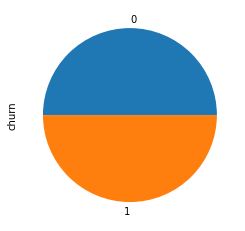

In [58]:
# After using oversampling technique, the training dataset is perfectly balanced.
y_train_res.value_counts().plot.pie()
plt.show()

## Model Building
- The input for a model is the resampled dataset obtained by SMOTE.
- **Predictive Model:**
    - PCA + Logistic regression
    - Random Forest
- **Interpretable Model:**
    - Decision Tree

### Predictive Model 1: PCA + Logistic Regression model
- PCA will handle dimensionalty reduction and multicollinearity.
- Logistic regression model is trained on the dataset processed through PCA and is used for prediction.

In [59]:
pca = PCA(random_state=42)
pca.fit(X_train_res)

PCA(random_state=42)

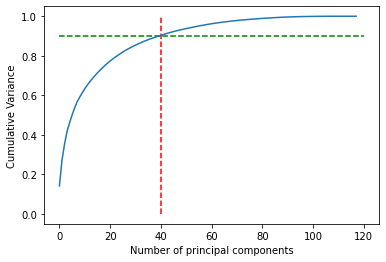

In [60]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumsum)
plt.vlines(x=40, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.90, xmax=120, xmin=0, colors="g", linestyles="--")
plt.xlabel('Number of principal components')
plt.ylabel('Cumulative Variance')
plt.show()

In [61]:
# Choosing 40 principal components which explains ~90% of the data.
pca_final = IncrementalPCA(n_components=40)
X_train_pca = pca_final.fit_transform(X_train_res)
print(X_train_pca.shape)

(38520, 40)


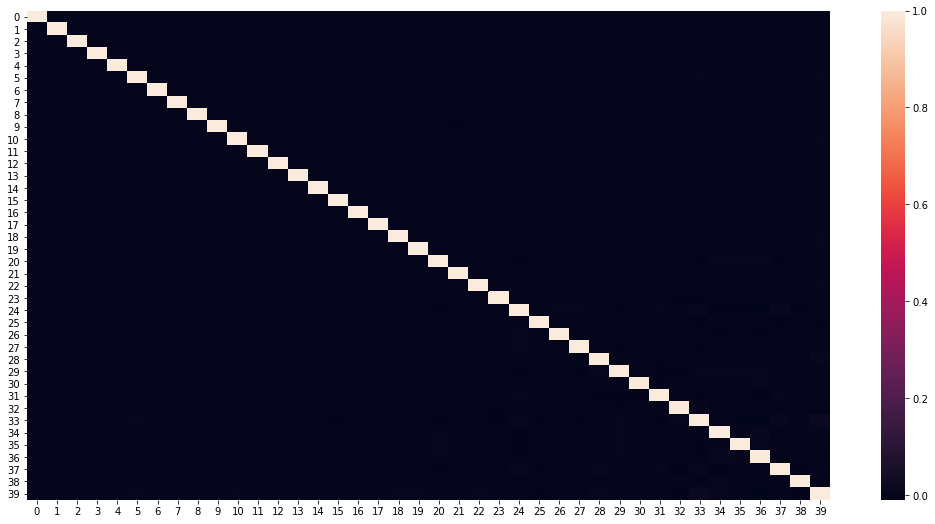

In [62]:
# The multicollinearity is handled through PCA.
corrmat = np.corrcoef(X_train_pca.transpose())
plt.figure(figsize=(18,9))
sns.heatmap(corrmat)
plt.show()

In [63]:
# Building a logistic regression model.
logreg = LogisticRegression()
logreg.fit(X_train_pca, y_train_res)

LogisticRegression()

In [64]:
# Predict on test dataset.
X_test_pca = pca_final.transform(X_test)
y_pred_proba = logreg.predict_proba(X_test_pca)[:, 1]

# Finding optimal threshold.
optimal_threshold = pd.DataFrame(columns=['churn', 'churn_prob', 'churn_class'])
optimal_threshold['churn'] = y_test
optimal_threshold['churn_prob'] = y_pred_proba
optimal_threshold['churn_class'] = optimal_threshold.churn_prob.map(lambda x: 1 if x > 0.5 else 0)
optimal_threshold

,churn,churn_prob,churn_class
7526,0,0.018282,0
74907,1,0.872015,1
99617,0,0.923959,1
83565,0,0.080248,0
8695,0,0.699802,1
...,...,...,...
59768,0,0.546513,1
349,0,0.043934,0
20916,0,0.055090,0
79866,0,0.426603,0


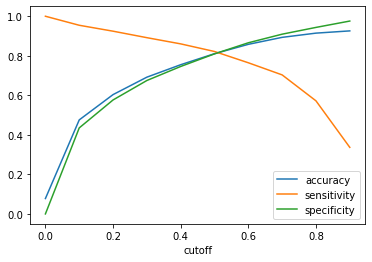

In [65]:
# Calculate the model's performance on different threshold levels, and determine the optimal threshold value.
threshold_scores = []
for cutoff in np.arange(0, 1, 0.1):
    optimal_threshold[cutoff] = optimal_threshold.churn_prob.map(lambda x: 1 if x > cutoff else 0)
    cm = metrics.confusion_matrix(y_test, optimal_threshold[cutoff])
    threshold_scores.append({
        'cutoff': cutoff,
        'accuracy': metrics.accuracy_score(y_test, optimal_threshold[cutoff]),
        'sensitivity': metrics.recall_score(y_test, optimal_threshold[cutoff]), # sensitivity is same as recall
        'specificity': cm[0,0]/(cm[0,0]+cm[0,1])
    })
threshold_df = pd.DataFrame(data=threshold_scores)
threshold_df.plot.line(x='cutoff', y=['accuracy', 'sensitivity', 'specificity'])
plt.show()

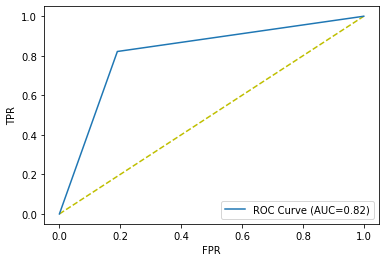

In [66]:
# Create final prediction labels based on "0.5" threshold
y_pred = optimal_threshold.churn_prob.apply(lambda x: 1 if x >= 0.5 else 0)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
auc = metrics.roc_auc_score(y_test, y_pred)
plt.plot([0,1], [0,1], 'y--')
plt.plot(fpr, tpr, label='ROC Curve (AUC=%0.2f)' % auc)
plt.legend(loc='lower right')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

#### Metric to evaluate: Sensitivity
- In our case, positive class is "churn" and negative class is "non-churn".
- If an observation is "positive"/churn, we must ensure that model shouldn't "falsely" predict as "negative"/non-churn. In other words, we should avoid **"False Negatives"**.
- Sensitivity is a metric which we can use to evaluate false negatives. Sensitivity is given by **TP/TP+FN**. If sensitivity is nearly equal to 1 indicates, the false negatives are nearly equal to 0.

In [67]:
# Define a function to evaluate model's performance on both training and testing datasets.
def evaluate_model(classifier, train, test):
    y_train_pred = classifier.predict(train)
    accuracy = metrics.accuracy_score(y_train_res, y_train_pred)
    sensitivity = metrics.recall_score(y_train_res, y_train_pred) # sensitivity is same as recall
    print('Accuracy and sensitivity of a model for training dataset is {} and {} respectively'.format(round(accuracy, 2), round(sensitivity, 2)))
    print('-'*90)
    y_test_pred = classifier.predict(test)
    accuracy = metrics.accuracy_score(y_test, y_test_pred)
    sensitivity = metrics.recall_score(y_test, y_test_pred) # sensitivity is same as recall
    print('Accuracy and sensitivity of a model for testing dataset is {} and {} respectively'.format(round(accuracy, 2), round(sensitivity, 2)))

evaluate_model(logreg, X_train_pca, X_test_pca)

Accuracy and sensitivity of a model for training dataset is 0.84 and 0.85 respectively
------------------------------------------------------------------------------------------
Accuracy and sensitivity of a model for testing dataset is 0.81 and 0.82 respectively


**Observations:**
- We have built a decent reliable model where the performance of the training and the testing dataset is comparable.
- Since our focus is mainly towards reducing the false negatives, we have achieved 82% sensitivity on the unseen dataset.

### Predictive Model 2: Random Forest Classifier model

In [68]:
# Build a random forest classifier.
rf = RandomForestClassifier(n_estimators=3, max_depth=10, random_state=42)
rf.fit(X_train_res, y_train_res)

RandomForestClassifier(max_depth=10, n_estimators=3, random_state=42)

In [69]:
# The performance on the training dataset is really good, but the sensitivity of the model has drastically dropped on the
# test dataset. There is a need to tune hyperparameters to improve model's performace.
evaluate_model(rf, X_train_res, X_test)

Accuracy and sensitivity of a model for training dataset is 0.93 and 0.95 respectively
------------------------------------------------------------------------------------------
Accuracy and sensitivity of a model for testing dataset is 0.89 and 0.73 respectively


#### Hyperparameter Tuning for random forest classifier using GridSearchCV

In [70]:
rf1 = RandomForestClassifier(random_state=42)
params = {
    'max_depth': [7, 10, 12, 15],
    'min_samples_leaf': [10, 15, 20],
    'max_features': [10, 12, 15, 20],
    'n_estimators': [50, 75, 100]
}
grid_search = GridSearchCV(estimator=rf1,
            param_grid=params,
            cv=4,
            n_jobs=-1,
            verbose=1,
            refit=True,
            scoring='recall')

# Build a grid search and find the best parameters.
grid_search.fit(X_train_res, y_train_res)

Fitting 4 folds for each of 144 candidates, totalling 576 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [7, 10, 12, 15],
                         'max_features': [10, 12, 15, 20],
                         'min_samples_leaf': [10, 15, 20],
                         'n_estimators': [50, 75, 100]},
             scoring='recall', verbose=1)

In [71]:
# Check for best parameters to tune the random forest classifier model.
grid_search.best_estimator_

RandomForestClassifier(max_depth=15, max_features=20, min_samples_leaf=10,
                       n_estimators=75, random_state=42)

In [72]:
# Build a final random forest classifier based on the best hyperparameters.
rf_final = RandomForestClassifier(max_depth=15, max_features=20, min_samples_leaf=10, n_estimators=75, random_state=42)
rf_final.fit(X_train_res, y_train_res)

RandomForestClassifier(max_depth=15, max_features=20, min_samples_leaf=10,
                       n_estimators=75, random_state=42)

In [73]:
# Evaluate model's performance after hyperparameter tuning.
evaluate_model(rf_final, X_train_res, X_test)

Accuracy and sensitivity of a model for training dataset is 0.97 and 0.98 respectively
------------------------------------------------------------------------------------------
Accuracy and sensitivity of a model for testing dataset is 0.92 and 0.72 respectively


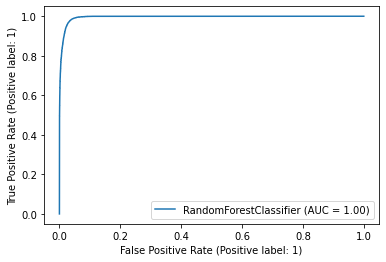

In [74]:
# Plot ROC.
metrics.plot_roc_curve(rf_final, X_train_res, y_train_res)
plt.show()

**Observations:**
- The performance on training dataset is excellent.
- The sensitivity on the test dataset is very low when compared to that of training dataset even after choosing best hyperparameters which indicates more number of misclassifications on unseen data.
- **We cannot afford losing more high value customers so we will go with model 1 (PCA + logistic regression) for prediction.**

### Interpretable Model: Decision Tree model
- Decision tree is immune to multicollinearity. We can feed the resampled data directly to train the decision trees instead of the dataset obtained from PCA.

In [75]:
# Plot tree built on decision trees.
def plot_tree(classifier, features):
    dot_data = StringIO()
    export_graphviz(classifier, out_file=dot_data, filled=True, rounded=True,
                   feature_names=features, class_names=['Non Churn', 'Churn'])
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return Image(graph.create_png())

#### Hyperparameter Tuning for decision tree classifier using GridSearchCV

In [76]:
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 8, 10, 20, 50, 100]
}
dtc = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(estimator=dtc,
            param_grid=params,
            cv=4,
            verbose=1,
            scoring='recall')

# Build a grid search and find the best parameters.
grid_search.fit(X_train_res, y_train_res)

Fitting 4 folds for each of 30 candidates, totalling 120 fits


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 8, 10, 20, 50, 100]},
             scoring='recall', verbose=1)

In [77]:
# Check for best parameters to tune the decision tree classifier model.
grid_search.best_estimator_

DecisionTreeClassifier(max_depth=10, min_samples_leaf=5, random_state=42)

In [78]:
# Build a decision tree classifier based on the best hyperparameters.
dtc1 = DecisionTreeClassifier(max_depth=10, min_samples_leaf=5, random_state=42)
dtc1.fit(X_train_res, y_train_res)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=5, random_state=42)

In [79]:
# Evaluate model's performance after hyperparameter tuning.
evaluate_model(dtc1, X_train_res, X_test)

Accuracy and sensitivity of a model for training dataset is 0.94 and 0.96 respectively
------------------------------------------------------------------------------------------
Accuracy and sensitivity of a model for testing dataset is 0.88 and 0.69 respectively


In [80]:
# Using RFE for feature selection by getting rid of unwanted features. We are considering top 40 features which are very 
# important to analyse and derive insights for business decisions.
rfe = RFE(dtc1, n_features_to_select=40)
rfe.fit(X_train_res, y_train_res)

RFE(estimator=DecisionTreeClassifier(max_depth=10, min_samples_leaf=5,
                                     random_state=42),
    n_features_to_select=40)

In [81]:
# Build a final decision tree classifier based on the important features.
rfe_supported_cols = list(X_train_res.columns[rfe.support_])
dtc_final = DecisionTreeClassifier(max_depth=10, min_samples_leaf=5, random_state=42)
dtc_final.fit(X_train_res[rfe_supported_cols], y_train_res)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=5, random_state=42)

In [82]:
# Evaluate model's performance after feature selection.
evaluate_model(dtc_final, X_train_res[rfe_supported_cols], X_test[rfe_supported_cols])

Accuracy and sensitivity of a model for training dataset is 0.94 and 0.96 respectively
------------------------------------------------------------------------------------------
Accuracy and sensitivity of a model for testing dataset is 0.88 and 0.67 respectively


In [83]:
# List down the important features with the most important one at the top.
feature_importance = pd.DataFrame({
    'Features': rfe_supported_cols,
    'Importance': dtc_final.feature_importances_
})
feature_importance.sort_values('Importance', ascending=False).head(40)

,Features,Importance
14,loc_ic_mou_8,0.409931
38,rech_before_eom_8,0.148355
33,fb_user_8,0.107029
25,last_day_rch_amt_8,0.081376
12,total_og_mou_8,0.024845
39,data_rech_before_eom_8,0.020260
24,last_day_rch_amt_7,0.019557
6,std_og_t2t_mou_7,0.015156
26,max_rech_data_8,0.012299
20,total_rech_num_7,0.011081


In [84]:
# Visualise the decision tree. Please zoom-in to see the nodes.
plot_tree(dtc_final, rfe_supported_cols)

InvocationException: GraphViz's executables not found

### Final Observations:
- It is clear from the decision tree that the most important feature is local incoming MOU in action phase which is the root node.
- Few of the other most important features includes recharge before end of month 8, fb user, total outgoing MOU 8 among others.

### Strategies:
- When customer decides to move out of the network, they eventually stop recharging their number and stop using the service.
- The recharge patterns of data and calls should to be monitored month-on-month basis to identify any trend which gives a cue that a customer might churn.
- Monitor the customer usage pattern to find any trend - calls (local, std), data, and fb.
- If a customer is likely to churn, provide them with great deal of offers like free 4G data service for next 3 months or offer to change the existing prepaid plan to cater their needs for free of cost to retain them since they're the high value customers.
- Based on the customer's location, check for any connectivity/network issues because of that s/he might not be able to use the service to the fullest. This could help many other customers in the same vicinity.